# USD-M perpetual (Binance-style) example

This example shows how to backtest a USD-M perpetual swap using `process_step!`
with mark updates and funding events. The CSV data is synthetic but shaped
like Binance USD-M: hourly bid/ask/last prices and a funding rate applied
every 8 hours (non-zero rows).

In [1]:
using Fastback
using Dates
using CSV
using DataFrames
using Statistics

---------------------------------------------------------

In [2]:
# load synthetic USD-M perp data
# columns: dt, bid, ask, last, funding_rate

data_path = "../data/usdm_perp_1h.csv";

# if data path doesn't exist, try to change working directory
isfile(data_path) || cd("src/examples")

# parse CSV (hourly rows)
df = DataFrame(CSV.File(data_path; dateformat="yyyy-mm-dd HH:MM:SS"));
sort!(df, :dt);

# quick sanity check
first(df, 5)

Row,dt,bid,ask,last,funding_rate
,DateTime,Float64,Float64,Float64,Float64
1,2024-01-01T00:00:00,41984.5,41992.9,41988.6,-9.0e-6
2,2024-01-01T01:00:00,42044.4,42052.8,42048.5,0.0
3,2024-01-01T02:00:00,41919.5,41927.9,41923.9,0.0
4,2024-01-01T03:00:00,41897.9,41906.3,41901.9,0.0
5,2024-01-01T04:00:00,41908.5,41916.8,41912.8,0.0


---------------------------------------------------------

In [3]:
# create margin account funded in USDT
acc = Account(; mode=AccountMode.Margin, base_currency=:USDT);
USDT = Cash(:USDT; digits=2);
deposit!(acc, USDT, 10_000.0);

# register a USD-M perpetual (variation margin, cash-settled)
perp = register_instrument!(acc, perpetual_instrument(
    Symbol("BTCUSDT-PERP"), :BTC, :USDT;
    margin_mode=MarginMode.PercentNotional,
    margin_init_long=0.10,
    margin_init_short=0.10,
    margin_maint_long=0.05,
    margin_maint_short=0.05,
    base_tick=0.001,
    quote_tick=0.1,
    base_digits=3,
    quote_digits=1,
));

# data collector for account equity and drawdowns (sampling every hour)
collect_equity, equity_data = periodic_collector(Float64, Hour(1));
collect_drawdown, drawdown_data = drawdown_collector(DrawdownMode.Percentage, Hour(1));

---------------------------------------------------------

In [4]:
# simple trend-following strategy
# - compute a 24h moving average
# - go long if price is >0.2% above MA
# - go short if price is >0.2% below MA
# - target ~3x notional leverage

window = 24;
deadband = 0.002;
leverage_target = 3.0;

for i in 1:nrow(df)
    row = df[i, :]
    dt = row.dt
    bid = row.bid
    ask = row.ask
    last = row.last
    funding_rate = row.funding_rate

    # apply marks and funding for this step
    marks = [MarkUpdate(perp.index, bid, ask, last)]
    funding = funding_rate == 0.0 ? nothing : [FundingUpdate(perp.index, funding_rate)]
    process_step!(acc, dt; marks=marks, funding=funding, liquidate=true)

    # trade after marks/funding (positions at funding timestamp are used)
    if i >= window
        ma = mean(@view df.last[i-window+1:i])
        signal = last > (1 + deadband) * ma ? 1.0 : (last < (1 - deadband) * ma ? -1.0 : 0.0)

        pos = get_position(acc, perp)
        target_qty = signal == 0.0 ? 0.0 : signal * leverage_target * equity(acc, :USDT) / last
        delta_qty = target_qty - pos.quantity

        if abs(delta_qty) > 1e-8
            order = Order(oid!(acc), perp, dt, last, delta_qty)
            fill_order!(acc, order; dt=dt, fill_price=last, bid=bid, ask=ask, last=last, commission_pct=0.0004)
        end
    end

    # collect data for plotting
    if should_collect(equity_data, dt)
        eq = equity(acc, :USDT)
        collect_equity(dt, eq)
        collect_drawdown(dt, eq)
    end
end

# close any remaining position at the end
row = df[end, :]
pos = get_position(acc, perp)
if pos.quantity != 0.0
    order = Order(oid!(acc), perp, row.dt, row.last, -pos.quantity)
    fill_order!(acc, order; dt=row.dt, fill_price=row.last, bid=row.bid, ask=row.ask, last=row.last, commission_pct=0.0004)
end

# summarize funding P&L
funding_pnl = sum(cf.amount for cf in acc.cashflows if cf.kind == CashflowKind.Funding)
println("Funding P&L (USDT): ", round(funding_pnl, digits=2))

# print account summary
show(acc)

Funding P&L (USDT): 18.96
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ ACCOUNT SUMMARY ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cash balances (1)
┌──────┬──────────┐
│      │    Value │
├──────┼──────────┤
│ USDT │ 13008.45 │
└──────┴──────────┘

Equity balances (1)
┌──────┬──────────┐
│      │    Value │
├──────┼──────────┤
│ USDT │ 13008.45 │
└──────┴──────────┘

Positions (0)

Trades (614)
┌─────┬──────────────┬─────────────────────┬────────┬────────┬─────────┬────┬───
│  ID │       Symbol │                Date │    Qty │ Filled │   Price │ TP │  ⋯
├─────┼──────────────┼─────────────────────┼────────┼────────┼─────────┼────┼───
│   1 │ BTCUSDT-PERP │ 2024-01-01 23:00:00 │ -0.717 │ -0.717 │ 41867.0 │  — │  ⋯
│   2 │ BTCUSDT-PERP │ 2024-01-02 00:00:00 │  0.717 │  0.717 │ 41909.8 │  — │  ⋯
│   3 │ BTCUSDT-PERP │ 2024-01-02 01:00:00 │ -0.713 │ -0.713 │ 41841.3 │  — │  ⋯
│   4 │ BTCUSDT-PERP │ 2024-01-02 02:00:00 │  0.713 │  0.713 │ 41908.6 │  — │  ⋯
│   5 │ BTCUSDT-PERP │ 2024-01-02 09:00:00 │  0.702 │  0.70

---------------------------------------------------------

### Plot account equity curve

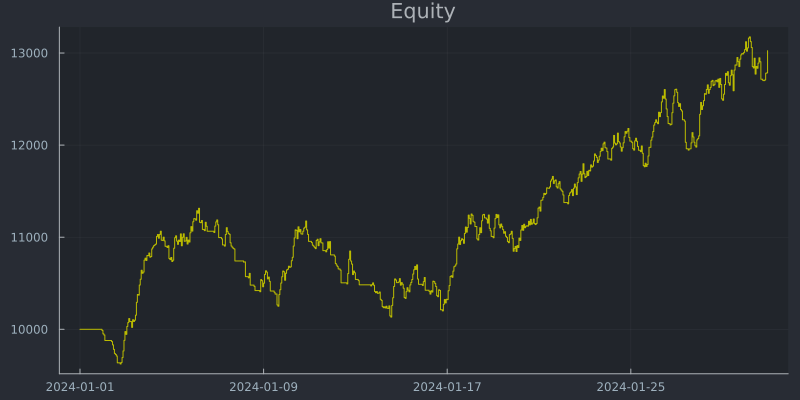

In [5]:
using Plots

theme(:juno)

Fastback.plot_equity(equity_data; size=(800, 400))

---------------------------------------------------------

### Plot account equity drawdown curve

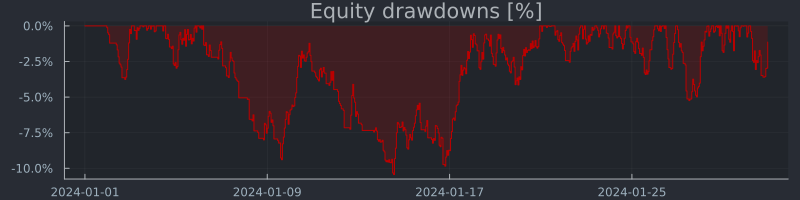

In [6]:
Fastback.plot_drawdown(drawdown_data; size=(800, 200))

---------------------------------------------------------

### Plot cashflows by type

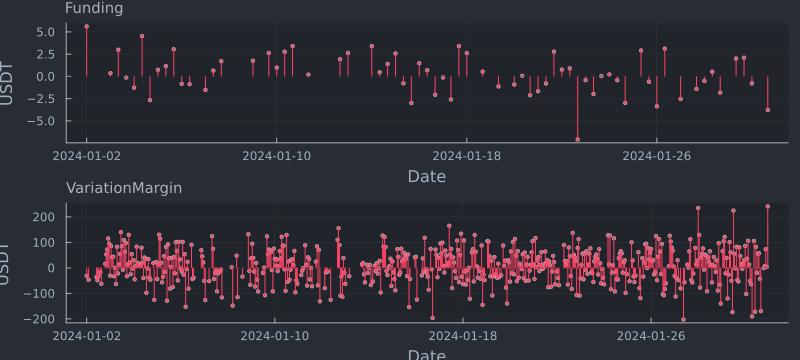

In [7]:
Fastback.plot_cashflows(acc)